In [2]:
import networkx as nx
import random
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from networkx.algorithms.community import kernighan_lin_bisection as kl_bisection

In [3]:
# Toy graph - undirected, unweighted
G = nx.gnm_random_graph(1000,2000)
G.remove_nodes_from(list(nx.isolates(G)))
# Toy flow graph - directed, weighted
num_nodes = 1000
num_edges = 2000
flowG = nx.DiGraph()
flowG.add_nodes_from(range(num_nodes))
for _ in range(num_edges):
    source, target = np.random.choice(range(num_nodes), size=2, replace=False)
    flowG.add_edge(source, target, capacity=np.random.uniform(0.0, 20.0))
flowG.remove_nodes_from(list(nx.isolates(flowG)))

In [4]:
def mincut_maxflow(G, num_splits):
    partitions = []
    
    def split(G, i):
        if i == 0 or G.number_of_nodes() <= 1:
            partitions.append(G)
        else:
            source = np.random.choice([node for node in G.nodes if G.in_degree(node)==0])
            sink = np.random.choice([node for node in G.nodes if G.out_degree(node)==0])
            while source == sink:
                sink = np.random.choice([node for node in G.nodes if G.out_degree(node==0)])
            part_A, part_B = nx.minimum_cut(G, source, sink)[1]
            A = split(G.subgraph(part_A), i-1)
            B = split(G.subgraph(part_B), i-1)
    
    split(G, num_splits)
    return partitions

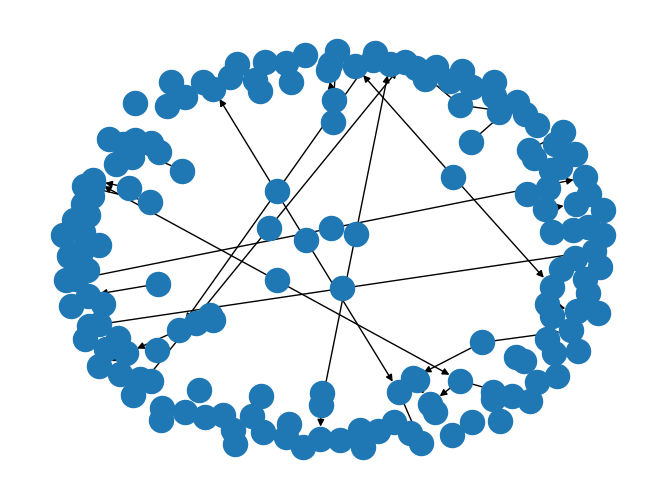

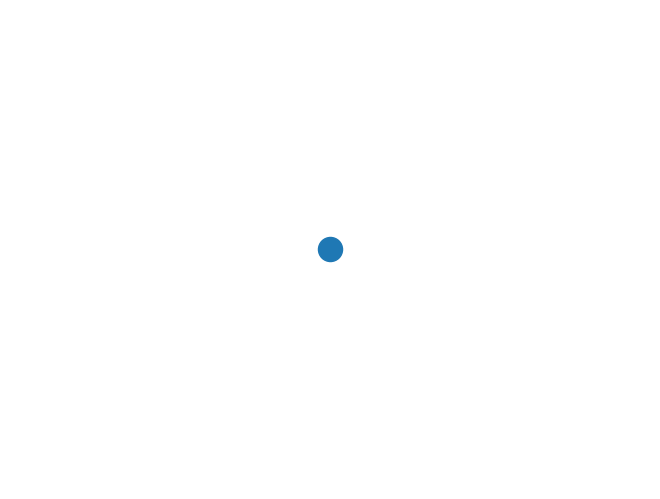

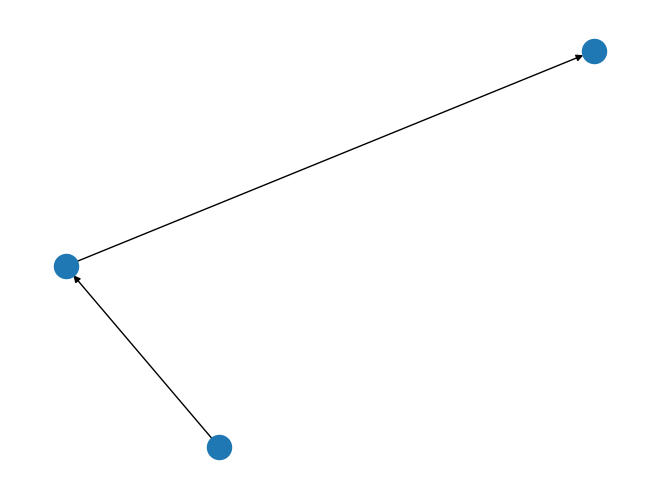

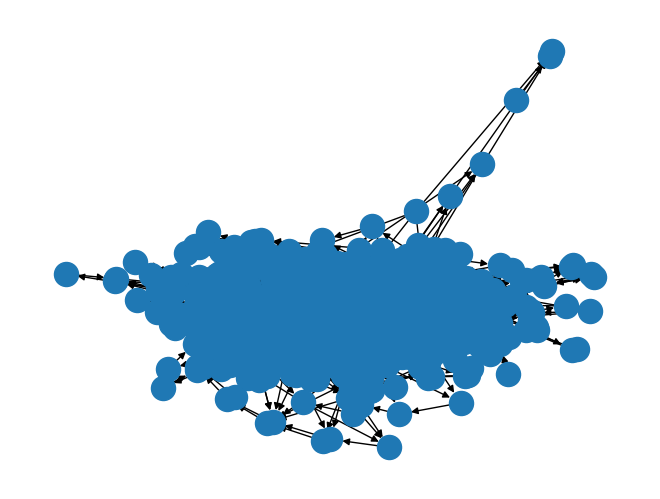

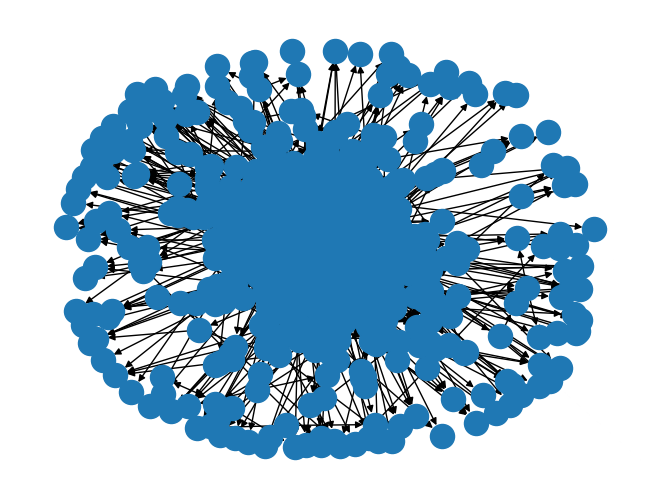

In [11]:
parts = 2
out = mincut_maxflow(flowG, parts)
for i in range(len(out)):
    plt.figure(i)
    nx.draw(out[i])
plt.figure(len(out))
nx.draw(flowG)

In [ ]:
def KL(G, num_splits, max_iter=len(G.nodes)//2):
    partitions = []
    
    def partition(G, i):
        if i == 0:
            partitions.append(G)
        else:
            part_A, part_B = kl_bisection(G, max_iter=max_iter)
            A = partition(G.subgraph(part_A), i - 1)
            B = partition(G.subgraph(part_B), i - 1)

    partition(G, num_splits)
    return partitions

In [ ]:
"""
n_splits = 3
out = KL(G, n_splits)
for i in range(n_splits):
    plt.figure(i)
    nx.draw(out[i])
plt.figure(n_splits)
nx.draw(G)
"""

In [ ]:
def calculate_initial_gain(G, node, partition):
    internal, external = 0, 0
    for neighbor in G[node]:
        if neighbor in partition:
            internal += G[node][neighbor].get('weight', 1)
        else:
            external += G[node][neighbor].get('weight', 1)
    return external - internal

def update_gains_and_queue(G, node, partition_a, partition_b, heap, node_to_heap):
    for neighbor in G[node]:
        if neighbor not in node_to_heap:
            continue
        if neighbor in partition_a:
            new_gain = calculate_initial_gain(G, neighbor, partition_a)
        else:
            new_gain = calculate_initial_gain(G, neighbor, partition_b)
        
        heap_entry = node_to_heap[neighbor]
        heap_entry[0] = -new_gain  # Negate for max-heap
        heapq.heapify(heap)  # Re-heapify

def is_balanced(partition_a, partition_b, max_imbalance):
    size_a = len(partition_a)
    size_b = len(partition_b)
    return abs(size_a - size_b) <= max_imbalance

In [ ]:
def fm_partition(G, max_passes=10, max_imbalance=1):
    nodes = list(G.nodes())  # Convert Nodes to a list
    random.shuffle(nodes)  # Shuffle to ensure random partitioning
    
    partition_a, partition_b = set(nodes[:len(G)//2]), set(nodes[len(G)//2:])
    heap = []
    node_to_heap = {}

    # Initialize gains and heap
    for node in G:
        gain = calculate_initial_gain(G, node, partition_a if node in partition_a else partition_b)
        heap_entry = [-gain, node]  # Negate gain for max-heap
        heapq.heappush(heap, heap_entry)
        node_to_heap[node] = heap_entry

    for _ in range(max_passes):
        if not heap:
            break

        # Find a suitable node to move
        while heap:
            gain, node = heapq.heappop(heap)
            gain = -gain  # Correct the negated gain

            if node in partition_a and is_balanced(partition_a - {node}, partition_b | {node}, max_imbalance):
                partition_a.remove(node)
                partition_b.add(node)
                break
            elif node in partition_b and is_balanced(partition_a | {node}, partition_b - {node}, max_imbalance):
                partition_b.remove(node)
                partition_a.add(node)
                break

        if not heap:
            # No suitable node found
            break

        # Lock this node
        del node_to_heap[node]

        # Update gains of neighbors
        update_gains_and_queue(G, node, partition_a, partition_b, heap, node_to_heap)

    return partition_a, partition_b

In [ ]:
def create_subgraphs(G, partition_a, partition_b):
    # Create subgraphs for each partition
    subgraph_a = G.subgraph(partition_a).copy()
    subgraph_b = G.subgraph(partition_b).copy()

    return subgraph_a, subgraph_b

In [ ]:
def multiple_fm(G, subgraphs, k, max_imbalance):
    
    if k == 0:
        subgraphs.append(G)
        return G
    
    p_a, p_b = fm_partition(G, k, max_imbalance)
    subgraph_a, subgraph_b = create_subgraphs(G, p_a, p_b)
    
    multiple_fm(subgraph_a, subgraphs, k - 1, max_imbalance)
    multiple_fm(subgraph_b, subgraphs, k - 1, max_imbalance)
    
    return subgraphs

In [ ]:
conn = np.load('../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

In [ ]:
edge_tensors = from_scipy_sparse_matrix(A)
edge_weights = edge_tensors[1]
edge_list = [(u.item(),v.item(), weight) for u, v, weight in zip(edge_tensors[0][0], edge_tensors[0][1], edge_weights)]

In [ ]:
G = nx.DiGraph()
G.add_weighted_edges_from(edge_list)
# G = nx.gnm_random_graph(1000, 2000)
dag = nx.graph.deepcopy(G)
subgraphs = []
subgraph_partitions = 3
max_imbalance = 10
partition_output = multiple_fm(dag, [], subgraph_partitions, max_imbalance)

In [ ]:
partition_output

In [ ]:
for i, p in enumerate(partition_output):
    print(f' {p.number_of_nodes()}, {p.number_of_edges()}')

In [ ]:
def reconstruct_dag(original_graph, reconstructed_dag, subgraph):
    # Add nodes and edges from subgraph
    for node in subgraph.nodes():
        reconstructed_dag.add_node(node)
    reconstructed_dag.add_edges_from(subgraph.edges())

    # Add inter-partition edges from original graph
    for u, v in original_graph.edges():
        if u in subgraph or v in subgraph:
            reconstructed_dag.add_edge(u, v, inter_partition=True)

    return reconstructed_dag

In [ ]:
# resconstructed_dag = nx.DiGraph()
# for i in range(len(partition_output)):
#     reconstructed_dag = reconstruct_dag(G, resconstructed_dag, partition_output[i])